In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests 
import numpy as np

#### I used **BeautifulSoup** and **Requests** to scrape the table from Wikipedia

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response = requests.get(url)

In [3]:
soup = BeautifulSoup(response.content,'html.parser')

In [4]:
tables = soup.find_all('table',class_='wikitable sortable')

In [5]:
for table in tables:
    ths = table.find_all('th')
    headings = [th.text.strip() for th in ths]
content=[]
for tr in table.find_all('tr'):
    tds = tr.find_all('td')
    row = [td.text.strip() for td in tds]
    content.append(row)
content = content[1:]

In [6]:
content[0:5]

[['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village'],
 ['M5A', 'Downtown Toronto', 'Harbourfront']]

#### This is the dataframe that exactly same as the table on Wikipedia

In [7]:
df = pd.DataFrame(columns=headings,data=content)
df.head(10)

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Queen's Park,Not assigned
8,M8A,Not assigned,Not assigned
9,M9A,Queen's Park,Queen's Park


Drop row if ***Borough*** is ***Not assigned***

In [8]:
df = df[df['Borough']!='Not assigned'].dropna()
df.head(10)

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Queen's Park,Not assigned
9,M9A,Queen's Park,Queen's Park
10,M1B,Scarborough,Rouge
11,M1B,Scarborough,Malvern
13,M3B,North York,Don Mills North


##### Combine the neighbourhoods if they are in the same borough

In [9]:
df = df.groupby(['Postcode','Borough'])['Neighbourhood'].apply(lambda x:', '.join(x.astype(str))).reset_index()
df.head(10)

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


#### Assign the borough name to neighbourhood if neighbourhood'name is not assigned

In [10]:
df['Neighbourhood'][df['Neighbourhood'] == 'Not assigned'] = df['Borough']
df.head(10)

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [11]:
df.shape

(103, 3)

## Collect latitude and longitude, and append to the dataframe 

In [12]:
import geocoder

In [13]:
#### 

In [14]:
'''# initialize your variable to None
lat_lng_coords = None

# loop until you get the coordinates
# get all postal code
latitude = []
longitude = []
for postal_code in df.Postcode.to_list():
    while(lat_lng_coords is None):
      g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
      lat_lng_coords = g.latlng

    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])'''

"# initialize your variable to None\nlat_lng_coords = None\n\n# loop until you get the coordinates\n# get all postal code\nlatitude = []\nlongitude = []\nfor postal_code in df.Postcode.to_list():\n    while(lat_lng_coords is None):\n      g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))\n      lat_lng_coords = g.latlng\n\n    latitude.append(lat_lng_coords[0])\n    longitude.append(lat_lng_coords[1])"

In [15]:
df_geo = pd.read_csv('Geospatial_Coordinates.csv')
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [16]:
df = df.merge(df_geo,left_on='Postcode',right_on='Postal Code',how='left')
df.drop(['Postal Code'],axis=1,inplace=True)

In [17]:
df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Create a map of Toronto with neighborhoods

In [18]:
import folium
from geopy.geocoders import Nominatim 
import json

In [19]:
#count how many unique boroughes in Toronto
print('There are {} boroughs in Toronto. They are {}'.format(df.Borough.nunique(),df.Borough.unique()))
# Use geopy library to get the latitude and longitude values of Toronto
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

There are 11 boroughs in Toronto. They are ['Scarborough' 'North York' 'East York' 'East Toronto' 'Central Toronto'
 'Downtown Toronto' 'York' 'West Toronto' "Queen's Park" 'Mississauga'
 'Etobicoke']
The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [20]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

# Github can't render folium map in notebook, please use the following link to render the map
# https://nbviewer.jupyter.org/github/chrisliuxq/IBM-Capstone/blob/master/clustering_neighborhoods_toronto.ipynb
map_toronto

## Define the problem and the Background
Tom lives in Highland Creek which is a neighbourhood in eastern Toronto, Ontario. He gets a new job in Etobicoke at the western part of Toronto. Without a car, the commute between the two places must be painful and it would take 2-hour，three transfers for one way. So Tom decide to move to a new place in Etobicoke to mitigate his pressure. His wants to find a neighborhood similar to Highland Creek. 

**Data Source**
<br />Data are collected from Foursquare. We will use information of venues to cluster the neighborhoods in Etobicode as well as Highland creek in order to find similar neighborhoods to Highland creek.

In [21]:
# Find all the neighborhoods in Borough in dataframe and concatenate with Highland Creek 
nbh = df[df['Borough']=='Etobicoke']
hc = df[df['Neighbourhood'].str.contains('Highland Creek')]
nbh = pd.concat([nbh,hc])

In [22]:
nbh

,Postcode,Borough,Neighbourhood,Latitude,Longitude
88,M8V,Etobicoke,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321
89,M8W,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484
90,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
91,M8Y,Etobicoke,"Humber Bay, King's Mill Park, Kingsway Park So...",43.636258,-79.498509
92,M8Z,Etobicoke,"Kingsway Park South West, Mimico NW, The Queen...",43.628841,-79.520999
94,M9B,Etobicoke,"Cloverdale, Islington, Martin Grove, Princess ...",43.650943,-79.554724
95,M9C,Etobicoke,"Bloordale Gardens, Eringate, Markland Wood, Ol...",43.643515,-79.577201
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv...",43.688905,-79.554724
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437


Let's explore what would be the responses from Foursquare API like

In [23]:
CLIENT_ID = 'JFDKDG3XPKST3YRQG4EQBE2IWO4UZ5WTOJLALMOSZU1OASHQ' # Foursquare ID
CLIENT_SECRET = 'HO1SWF1Z4GH4QHKFKOFXXFFYO5NECIT15RYAV4OVJGTPKXJ4' # Foursquare Secret
VERSION = '20191120' # Foursquare API version

In [24]:
url = 'https://api.foursquare.com/v2/venues/search?\
client_id={}&client_secret={}\
&ll=43.784535,-79.160479\
&v={}\
&radius=1000\
&limit=2'.format(CLIENT_ID, CLIENT_SECRET, VERSION) 

response = requests.get(url).json()
response['response']['venues']

[{'id': '4c38d4ab18e72d7fb01d19f5',
  'name': 'Colonel Danforth Park',
  'location': {'lat': 43.7775073613354,
   'lng': -79.16430271940706,
   'labeledLatLngs': [{'label': 'display',
     'lat': 43.7775073613354,
     'lng': -79.16430271940706}],
   'distance': 840,
   'cc': 'CA',
   'city': 'Toronto',
   'state': 'ON',
   'country': 'Canada',
   'formattedAddress': ['Toronto ON', 'Canada']},
  'categories': [{'id': '4bf58dd8d48988d1e7941735',
    'name': 'Playground',
    'pluralName': 'Playgrounds',
    'shortName': 'Playground',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/playground_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1574491985',
  'hasPerk': False},
 {'id': '4c23d3aaf7ced13a5ed7216d',
  'name': 'Royal Canadian Legion',
  'location': {'address': '45 Lawson Rd',
   'lat': 43.78253332838298,
   'lng': -79.16308473261682,
   'labeledLatLngs': [{'label': 'display',
     'lat': 43.78253332838298,
     'lng': -79.1630847

In [25]:
# Get venus information within these areas. Find venues' categories as a standard of "similar neightborhood". 
# Set radius to 2000m， sounds reasonable 
latitude = nbh.Latitude.values.tolist()
longitude = nbh.Longitude.values.tolist()
radius = 2000
category_names = []

for i in range(len(nbh)):
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, latitude[i], longitude[i], VERSION, radius) 
    response = requests.get(url).json()
    if len(response['response'])==0:
        cat_name = []
        category_names.append(cat_name)
    else:  
        venues = response['response']['venues']
        cat_name = []
        for j in range(len(venues)):
            for k in range(len(venues[j]['categories'])):
                cat_name.append(venues[j]['categories'][k]['name'])
        category_names.append(cat_name)    

In [26]:
# Check what venues' categories we have in M8V
category_names[0]

['Middle School',
 'Coworking Space',
 'General College & University',
 'Athletics & Sports',
 'Light Rail Station',
 'Miscellaneous Shop',
 'Intersection',
 'Sandwich Place',
 'Yoga Studio',
 'Housing Development',
 'Coworking Space',
 'Athletics & Sports',
 "Dentist's Office",
 'Fast Food Restaurant',
 'IT Services',
 'Office',
 'Office',
 'Other Nightlife',
 'Lounge',
 'Park',
 'Factory',
 'Rock Club',
 'Housing Development',
 'Breakfast Spot',
 'Park']

In [27]:
# Check unique categories we have in total 
from itertools import chain
total_categories = set(list(chain.from_iterable(category_names)))
len(total_categories)

138

In [28]:
# Add these categories as features to the dataframe
features = nbh
vector = [0]*12
for i in total_categories:
    features[i] = vector
    
# reset index for features dataframe
features.reset_index(drop=True, inplace=True)

In [29]:
# Encode the features: if the area has such feature, it will be encoded as 1, or 0.
for i in range(len(nbh)):
    for j in features.columns[5:]:
        if j in category_names[i]:
            features.loc[i,j]=1            

In [30]:
features.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Event Space,ATM,Movie Theater,Government Building,Gas Station,...,Sculpture Garden,Liquor Store,Middle Eastern Restaurant,Factory,Housing Development,Playground,Parking,Fast Food Restaurant,Breakfast Spot,Bus Station
0,M8V,Etobicoke,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321,0,0,0,0,0,...,0,0,0,1,1,0,0,1,1,0
1,M8W,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
2,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,M8Y,Etobicoke,"Humber Bay, King's Mill Park, Kingsway Park So...",43.636258,-79.498509,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,M8Z,Etobicoke,"Kingsway Park South West, Mimico NW, The Queen...",43.628841,-79.520999,0,0,0,1,0,...,0,0,0,1,0,0,1,1,0,0


### Cluster Neighborhoods by features
run K-means to cluster the neiborhoods

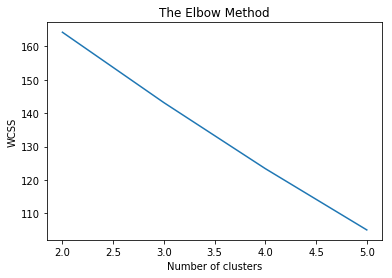

In [31]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
# using the elbow method to find the optimal number of clusters
# the dataset is small so I didn't split the dataset into training and testing
X = features.iloc[:,5:].values
wcss=[]
for i in range(2,6):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 6), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [32]:
# decide k=3, fitting k-means to the dataset
k = 3
kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state=0)
y_kmeans = kmeans.fit_predict(X)

# check cluster labels
print('Label for each area: {}'.format(kmeans.labels_.tolist()))

# append cluster labels to dataframe
features['label']=kmeans.labels_.tolist()

Label for each area: [0, 2, 1, 1, 0, 0, 2, 1, 1, 1, 1, 1]


In [33]:
# Visualizing the clusters on map
import matplotlib.cm as cm
import matplotlib.colors as colors
# Initialize the map first
map_clusters = folium.Map(location=[location.latitude,location.longitude],zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map,  
markers_colors = []
for lat, lon, poi, cluster in zip(features['Latitude'], features['Longitude'], features['Neighbourhood'], features['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters


### Tom can choose the following neighborhoods close to his new workplace if he would like to live in a neighborhood resembles Highland Creek.

In [34]:
# check neighborhoods in cluster 0
results = features[features['label']==0]['Neighbourhood'].tolist()

lst = [i.split(',') for i in results]
for i in lst:
    for j in i:
        print(j)

Humber Bay Shores
 Mimico South
 New Toronto
Kingsway Park South West
 Mimico NW
 The Queensway West
 Royal York South West
 South of Bloor
Cloverdale
 Islington
 Martin Grove
 Princess Gardens
 West Deane Park
